# Other AQUA tools and Reader methods

In this notebook we explore some extra Reader methods and graphing tools that can be used to analyze the data.
Let's see the most common methods and tools that can be used to analyze the data.

Reader methods:

- `fldmean`: area-weighted mean of a field, with possibility of area selection
- `detrend`: detring based on polyfit and on the time axis
- `info`: print information about the dataset
- `stream`: not explained here, but it allows to retrieve data chunk by chunk, for efficient memory usage and parallel processing
- `timmean`: temporal aggregation of data

While we explore the usage of different methods we will also use some graphing tools to visualize the data. These are available in the `aqua.graphics` module.

In [1]:
from aqua import Reader

In [2]:
reader_era = Reader(model='ERA5', exp='era5', source='monthly')
reader_ifs_fesom = Reader(catalog='nextgems4', model='IFS-FESOM', exp='historical-1990', source='lra-r100-monthly')

2024-10-09 17:48:03 :: Reader :: WARNING  -> FDB_PATH parameter is required but is missing, setting to default 
2024-10-09 17:48:03 :: Reader :: WARNING  -> The requested default fixer name IFS-FESOM-default does not exist in fixes files
2024-10-09 17:48:03 :: Reader :: WARNING  -> No fixes available for model IFS-FESOM, experiment historical-1990, source lra-r100-monthly


In [3]:
data_era = reader_era.retrieve()
data_ifs_fesom = reader_ifs_fesom.retrieve()

Let's try to do a seasonal cycle of the IFS-FESOM run for the temperature field. This will allow us to see many of the methods and tools in action.

In [4]:
ifs_fesom_global_mtpr = reader_ifs_fesom.fldmean(data_ifs_fesom['mtpr'])
seasonal_cycle_ifs_fesom_mtpr = ifs_fesom_global_mtpr.groupby('time.month').mean('time')

The two lines of code were enough to evaluate the global mean with the AQUA tools and create a simple seasonal cycle with xarray tools.

/pfs/lustrep3/projappl/project_465000454/nurissom/AQUA/src/aqua/graphics/timeseries.py:192: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize='small')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'IFS-FESOM historical 1990 precipitation'}, xlabel='month', ylabel='Mean total precipitation rate\n[kg m**-2 s**-1]'>)

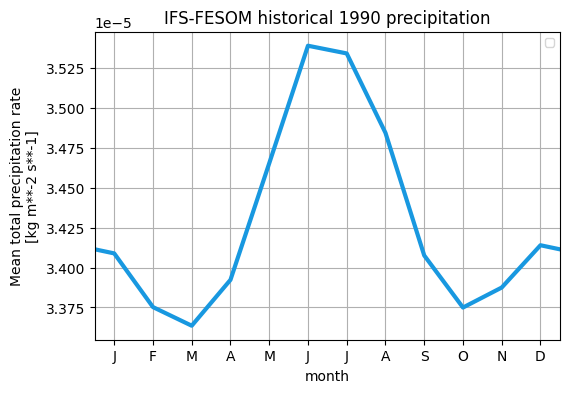

In [5]:
from aqua.graphics import plot_seasonalcycle

plot_seasonalcycle(data=seasonal_cycle_ifs_fesom_mtpr, title='IFS-FESOM historical 1990 precipitation')

Let's now try another exercise. Let's do an annual timeseries for the global mean temperature of Italy. How was the temperature in Italy from the 1990s to today?
We consider a box with limits 6.5E, 18.5E, 36.5N, 47.5N.
Let's try to plot it and be sure it is correct.

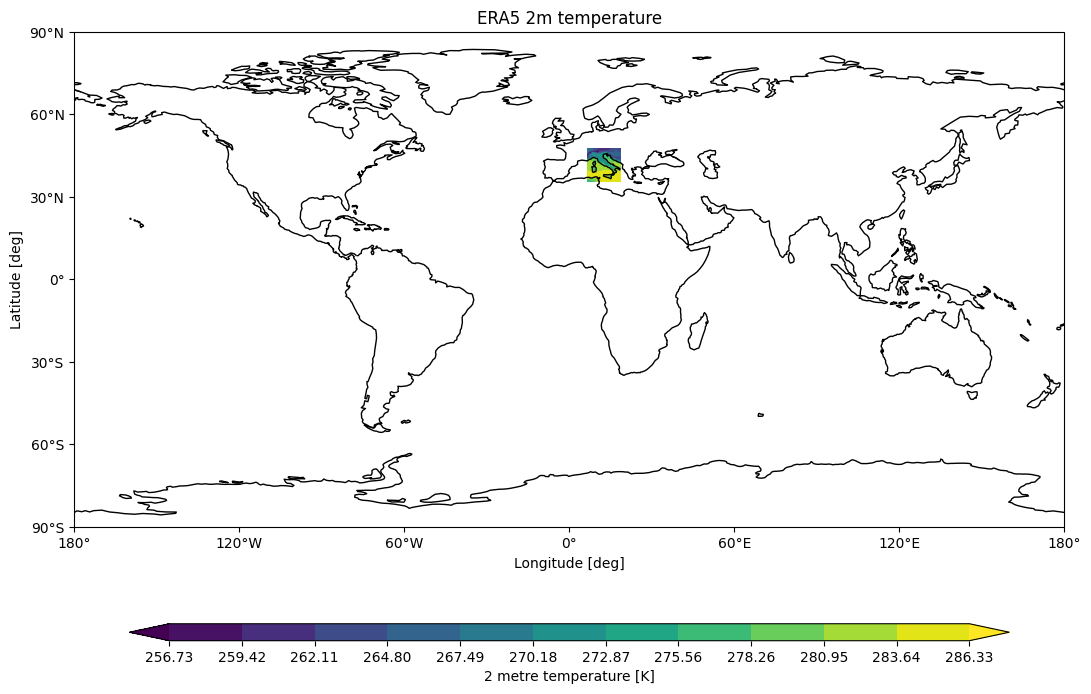

In [6]:
from aqua.util import area_selection
from aqua.graphics import plot_single_map
italy_2t = area_selection(data_era['2t'], lat=(47.5, 35.5), lon=(6.5, 18.5))
plot_single_map(data=italy_2t.isel(time=0), title='ERA5 2m temperature', cmap='viridis')

Now let's do the annual timeseries:

In [7]:
global_2t = data_era['2t'].sel(time=slice('1981', '2023'))
global_2t_annual = reader_era.timmean(global_2t, freq='YS', exclude_incomplete=True, center_time=True)
italy_2t_ts = reader_era.fldmean(global_2t_annual, lat_limits=(47.5, 35.5), lon_limits=(6.5, 18.5))

Notice that now the area selection has been used directly as embedded arguments in the `fldmean` method.

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'ERA5 2m temperature in Italy 1990-2023'}, xlabel='time', ylabel='2 metre temperature [K]'>)

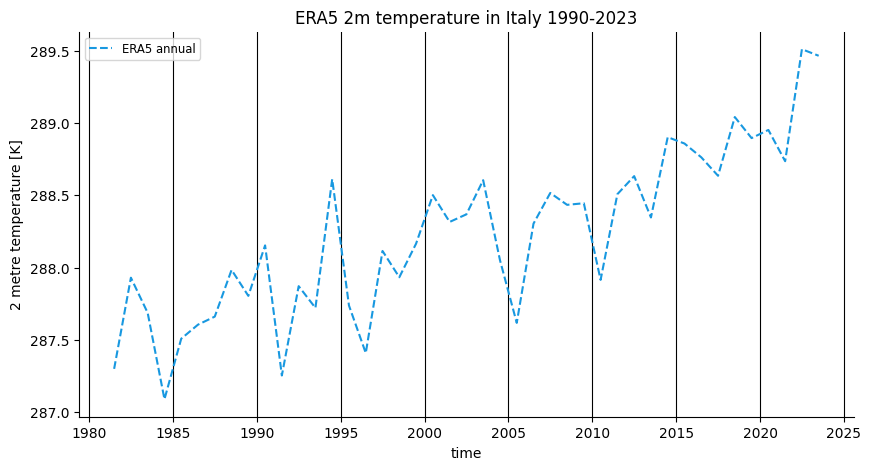

In [8]:
from aqua.graphics import plot_timeseries

plot_timeseries(annual_data=[italy_2t_ts], title='ERA5 2m temperature in Italy 1990-2023', data_labels=['ERA5'])

Let's finally try to detrend the data and see a difference in a random date.

In [9]:
italy_2t_annual = area_selection(global_2t_annual, lat=(47.5, 35.5), lon=(6.5, 18.5))
italy_variability = reader_era.detrend(italy_2t_annual)
italy_mean = italy_2t_annual.mean('time')

italy_detrend = italy_variability + italy_mean

In [10]:
italy_detrend_plot = area_selection(italy_detrend.sel(time='2023'), lat=(47.5, 35.5), lon=(6.5, 18.5), drop=True).isel(time=0)
italy_2t_annual_plot = area_selection(italy_2t_annual.sel(time='2023'), lat=(47.5, 35.5), lon=(6.5, 18.5), drop=True).isel(time=0)

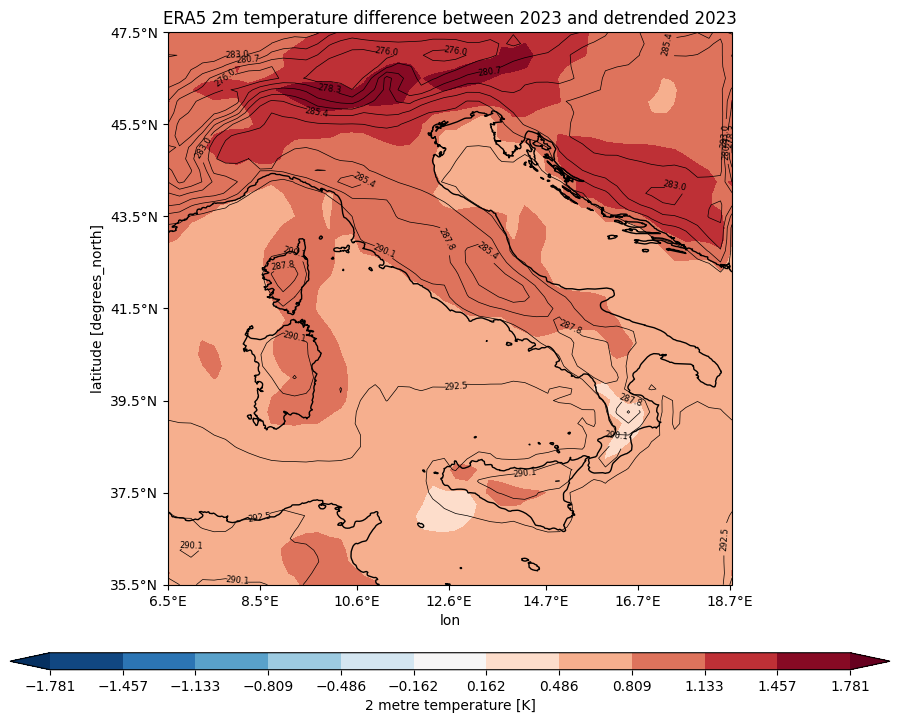

In [11]:
from aqua.graphics import plot_single_map_diff

plot_single_map_diff(data=italy_2t_annual_plot, data_ref=italy_detrend_plot,
                     title='ERA5 2m temperature difference between 2023 and detrended 2023')